In [2]:
#pip install -r requirements.txt
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display
from folium import Choropleth
from shapely.geometry import shape



/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Accès à la base de données sur l'éclairage depuis une API et importation du DataFrame

Nous importons depuis l'API de opendata Paris une base contenant des informations sur l'ensemble des points lumineux de la ville de Paris. La base contient 69 classes, nous appliquons donc un filtre pour ne sélectionner que celles qui sont pertinentes ou permettent une compréhension de la structure de la base. 

In [3]:
api_root_eclairage = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/"
ID_eclairage = "eclairage-public"
url_api_eclairage = api_root_eclairage + ID_eclairage + "/exports/json" + "?select=cod_ouvrag,foyer,lib_domain,lib_ouvrag,posx_ouvra,posy_ouvra,lib_regime,voievent_v,numvoie_ou,nature_voi,lib_voie,lib_voiedo,lib_secteu,lib_region,lib_regi_1,geo_shape"
print(url_api_eclairage)

try:
    response = requests.get(url_api_eclairage)
    response.raise_for_status()
    wb = response.json()
except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête : {e}")
except ValueError:
    print("Erreur : Impossible de décoder le JSON.")


df_eclairage_flt = pd.DataFrame(wb)
df_eclairage_flt.head()

https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/eclairage-public/exports/json?select=cod_ouvrag,foyer,lib_domain,lib_ouvrag,posx_ouvra,posy_ouvra,lib_regime,voievent_v,numvoie_ou,nature_voi,lib_voie,lib_voiedo,lib_secteu,lib_region,lib_regi_1,geo_shape


,cod_ouvrag,foyer,lib_domain,lib_ouvrag,posx_ouvra,posy_ouvra,lib_regime,voievent_v,numvoie_ou,nature_voi,lib_voie,lib_voiedo,lib_secteu,lib_region,lib_regi_1,geo_shape
0,O08769,1813355,Eclairage Public,Candélabre,651442.266129,6.864901e+06,HORAIRE EP,CLICHY (BOULEVARD DE),C 15,BD,CLICHY (BOULEVARD DE),VOIES PUBLIQUES,18_CLIGNANCOURT,Arrondissement 18,STV Nord Ouest,"{'type': 'Feature', 'geometry': {'coordinates'..."
1,O05750,1703524,Eclairage Public,Candélabre,649303.695502,6.864724e+06,HORAIRE EP,COURCELLES (BOULEVARD DE),F 50,BD,COURCELLES (BOULEVARD DE),VOIES PUBLIQUES,17_PLAINE MONCEAU,Arrondissement 17,STV Nord Ouest,"{'type': 'Feature', 'geometry': {'coordinates'..."
2,O09222,506142,Eclairage Public,Console,651951.912804,6.860320e+06,HORAIRE EP,RATAUD (RUE),A 04 BIS,RUE,RATAUD (RUE),VOIES PUBLIQUES,05_VAL DE GRACE,Arrondissement 05,STV Sud,"{'type': 'Feature', 'geometry': {'coordinates'..."
3,O19768,O19768,Eclairage Public,Galerie,648789.336276,6.862934e+06,HORAIRE EP,ALMA - CIRCUIT JOUR - COTE PARIS,None,SOU,ALMA - CIRCUIT JOUR - COTE PARIS,SOUTERRAINS,ALMA NEW YORK,Arrondissement 08,STBP,"{'type': 'Feature', 'geometry': {'coordinates'..."
4,O19787,O19787-2,Eclairage Public,Galerie,648809.586191,6.862922e+06,HORAIRE EP,ALMA :TREMIE CRS ALBERT 1er (SOUTERRAIN),None,SOU,ALMA - CIRCUIT JOUR - COTE SEINE,SOUTERRAINS,ALMA NEW YORK,Arrondissement 08,STBP,"{'type': 'Feature', 'geometry': {'coordinates'..."


In [4]:
df_eclairage_flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171226 entries, 0 to 171225
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   cod_ouvrag  171226 non-null  object 
 1   foyer       171226 non-null  object 
 2   lib_domain  171226 non-null  object 
 3   lib_ouvrag  171226 non-null  object 
 4   posx_ouvra  171226 non-null  float64
 5   posy_ouvra  171226 non-null  float64
 6   lib_regime  171223 non-null  object 
 7   voievent_v  171226 non-null  object 
 8   numvoie_ou  100037 non-null  object 
 9   nature_voi  171226 non-null  object 
 10  lib_voie    171226 non-null  object 
 11  lib_voiedo  171226 non-null  object 
 12  lib_secteu  171226 non-null  object 
 13  lib_region  171226 non-null  object 
 14  lib_regi_1  171226 non-null  object 
 15  geo_shape   171226 non-null  object 
dtypes: float64(2), object(14)
memory usage: 20.9+ MB


Nous observons le format des données dans la classe contenant l'arrondissement car nous aurons besoin de faire une transformation plus tard dans le code afin d'unifier cette colonne avec les autres bases. Nous avons également observé plus haut le nombre de points lumineux total, chose qui sera primordiale pour la représentation graphique.

In [9]:
df_eclairage_flt['lib_region']

0         Arrondissement 18
1         Arrondissement 17
2         Arrondissement 05
3         Arrondissement 08
4         Arrondissement 08
                ...        
171221    Arrondissement 08
171222    Arrondissement 08
171223    Arrondissement 14
171224    Arrondissement 15
171225    Arrondissement 08
Name: lib_region, Length: 171226, dtype: object

## Statistiques descriptives 

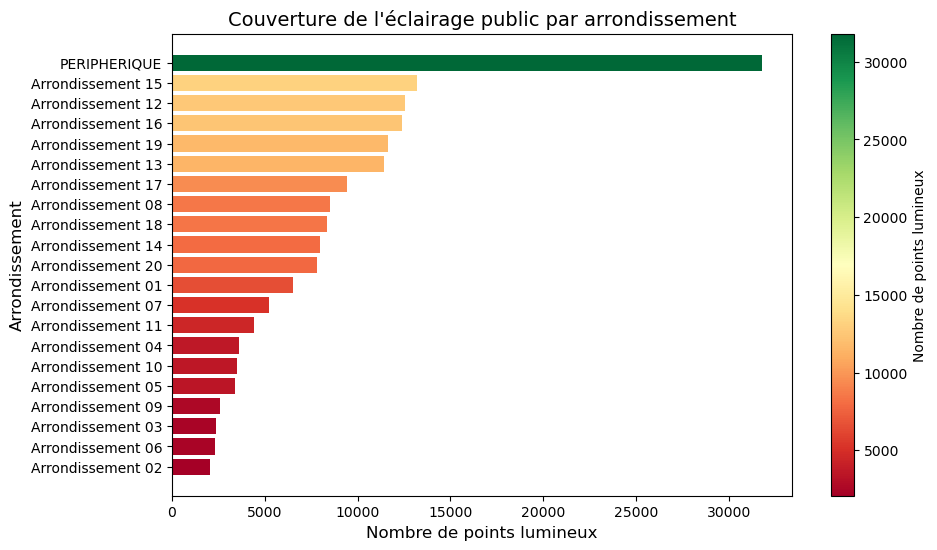

In [10]:
coverage_by_arrondissement = df_eclairage_flt['lib_region'].value_counts()
coverage_sorted = coverage_by_arrondissement.sort_values()
norm = mcolors.Normalize(vmin=coverage_sorted.min(), vmax=coverage_sorted.max())
cmap = plt.cm.RdYlGn
colors = [cmap(norm(value)) for value in coverage_sorted]
plt.figure(figsize=(10, 6))
plt.barh(coverage_sorted.index, coverage_sorted.values, color=colors)
plt.xlabel("Nombre de points lumineux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de l'éclairage public par arrondissement", fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Nombre de points lumineux")
plt.show()


Nous observons le nombre de points lumineux par arrondissement et effectuons un classement. Cependant, ce classement n'est pas significatif car nous ne prenons pas en compte la différence de taille entre les arrondissements. Nous allons donc importer une seconde base qui contient les surfaces de chaque arrondissement afin de calculer la densité des points lumineux et re effectuer le classement.

## Importation d'une base contenant les arrondissements de Paris depuis une API

In [28]:
url_api_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/records?limit=20"
response2 = requests.get(url_api_arrondissements)
data = response2.json() 
results = data.get("results", []) 
df_arrondissements = pd.DataFrame(results)
df_arrondissements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   n_sq_ar    20 non-null     int64  
 1   c_ar       20 non-null     int64  
 2   c_arinsee  20 non-null     int64  
 3   l_ar       20 non-null     object 
 4   l_aroff    20 non-null     object 
 5   n_sq_co    20 non-null     int64  
 6   surface    20 non-null     float64
 7   perimetre  20 non-null     float64
 8   geom_x_y   20 non-null     object 
 9   geom       20 non-null     object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.7+ KB


Nous ne sélectionnons que les classes dont on aura besoin et nous transformons l'unité de la surface en km2 pour maintenir un ordre de grandeur.

In [17]:
df_arrondissements_flt = df_arrondissements[['c_ar','c_arinsee', 'l_ar', 'surface', 'geom']]
df_arrondissements_flt.loc[:, 'surface'] = df_arrondissements_flt['surface'] / 1e6
df_arrondissements_flt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   c_ar       20 non-null     int64  
 1   c_arinsee  20 non-null     int64  
 2   l_ar       20 non-null     object 
 3   surface    20 non-null     float64
 4   geom       20 non-null     object 
dtypes: float64(1), int64(2), object(2)
memory usage: 928.0+ bytes


## Réalisation d'une jointure avec la base d'éclairage

Comme mentionné plus haut, nous transformons la colonne 'lib_region' en code INSEE pour unifier la clé dans toutes les bases. Nous utilisons une fonction différente de celle utilisée dans d'autres bases car "lib_region" contient une chaine de caractère, le traitement est donc adapté.

In [16]:
def extraire_insee(arrondissement):
    parts = arrondissement.split(' ')  
    if len(parts) > 1:
        num = parts[1] 
        return f'751{int(num):02d}'  
    else:
        return 'Code non trouvé'  

df_eclairage_flt['num_region'] = df_eclairage_flt['lib_region'].apply(extraire_insee)
df_eclairage_flt['num_region'].head()

0    75118
1    75117
2    75105
3    75108
4    75108
Name: num_region, dtype: object

Après avoir transformé 'num_region" en format numérique nous réalisons une jointure entre les deux bases en ne sélectionnant que la colonne *geo_shape* qui nous permettera de calculer le nombre de points lumineux.

In [20]:
df_eclairage_flt['num_region'] = pd.to_numeric(df_eclairage_flt['num_region'], errors='coerce')

df_combined = pd.merge(
    df_eclairage_flt[['geo_shape', 'num_region']],
    df_arrondissements_flt, 
    left_on='num_region',  
    right_on='c_arinsee',      
    how='inner'            
)
df_combined = df_combined.rename(columns={
    'surface': 'surface_arr',
    'geom': 'geom_arr'
})
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139424 entries, 0 to 139423
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   geo_shape    139424 non-null  object 
 1   num_region   139424 non-null  float64
 2   c_ar         139424 non-null  int64  
 3   c_arinsee    139424 non-null  int64  
 4   l_ar         139424 non-null  object 
 5   surface_arr  139424 non-null  float64
 6   geom_arr     139424 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 7.4+ MB


## Représentation de la densité des points lumineux par arrondissement

Après calcul du nombre total de points lumineux nous réalisons une seconde jointure afin d'obtenir le DataFrame *df_densite* qui contient le nom de l'arrondissement, le nombre de points lumineux qu'il contient et sa surface. Puis nous calculons la densité grâce à une formule simple, le rajoutons au Dataframe et affichons le résultat.

In [22]:
coverage_by_arrondissement2 = df_combined['c_arinsee'].value_counts()
coverage_df = coverage_by_arrondissement2.reset_index()
coverage_df.columns = ['c_arinsee', 'Nombre_points_lumineux']

df_densite = pd.merge(
    df_arrondissements_flt,
    coverage_df,
    on='c_arinsee',
    how='left'  
)



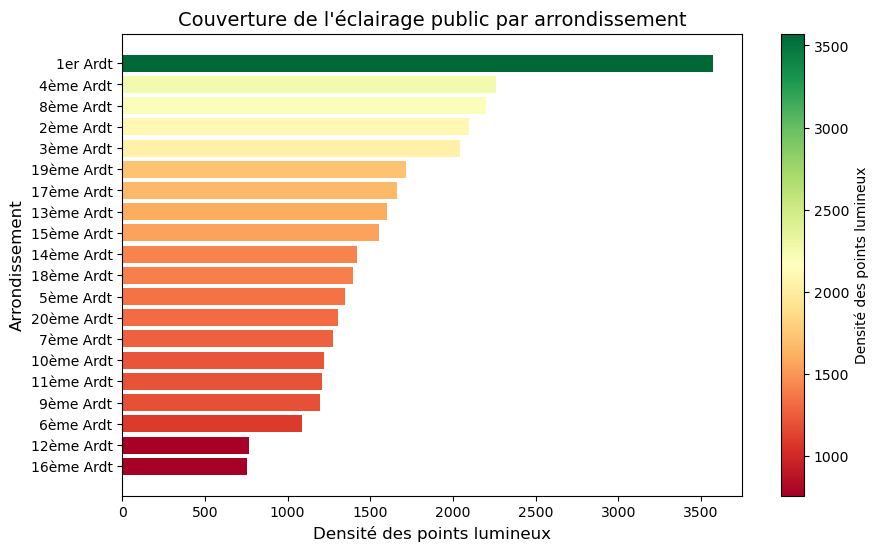

In [23]:
df_densite['densité_lum'] = df_densite['Nombre_points_lumineux'] / df_densite['surface']

coverage_sorted = df_densite.sort_values(by='densité_lum', ascending=True)
norm = mcolors.Normalize(vmin=coverage_sorted['densité_lum'].min(), vmax=coverage_sorted['densité_lum'].max())
cmap = plt.cm.RdYlGn  
colors = [cmap(norm(value)) for value in coverage_sorted['densité_lum']]

plt.figure(figsize=(10, 6))
plt.barh(coverage_sorted['l_ar'], coverage_sorted['densité_lum'], color=colors)
plt.xlabel("Densité des points lumineux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de l'éclairage public par arrondissement", fontsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Densité des points lumineux")

plt.show()


Nous remarquons que le classement est totalement différent comparé au premier. Il était donc bien plus pertinent de l'effectuer en prenant en compte la densité.

Nous modifions finalement le nom de la colonne *c_arinsee* car nous allons utiliser le DataFrame *df_densite* pour réaliser la jointure finale avec les autres bases afin de pouvoir appliquer le modèle de régression.

In [27]:
df_densite = df_densite.rename(columns={
    'c_arinsee': 'INSEE_COG'
})
df_densite.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   c_ar                    20 non-null     int64  
 1   INSEE_COG               20 non-null     int64  
 2   l_ar                    20 non-null     object 
 3   surface                 20 non-null     float64
 4   geom                    20 non-null     object 
 5   Nombre_points_lumineux  20 non-null     int64  
 6   densité_lum             20 non-null     float64
 7   geometry                20 non-null     object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.4+ KB


## Représentation sur une carte

In [14]:
!pip install folium
!pip install ipython
#pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
df_eclairage_flt['geometry'] = df_eclairage_flt['geo_shape'].apply(lambda x: Point(x['geometry']['coordinates']))
gdf_eclairage = gpd.GeoDataFrame(df_eclairage_flt, geometry='geometry', crs="EPSG:4326")
gdf_eclairage_sample = gdf_eclairage.sample(frac=0.01) #Séléction aléatoire de 1% des données au vu de leur taille 

m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
for _, row in gdf_eclairage_sample.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=0.5,
        color='yellow',
        fill=True,
        fill_color='yellow'
    ).add_to(m)

display(m)


Nosu avons observé précedemment que la base contenait plus de 170.000 points, par soucis de gestion de mémoire et de performances nous n'affichons que 1% des points lumineux choisis aléatoirement.

Nous affichons maintenant une carte interactive qui permet de visualiser la densité lumineuse en utilisant le code couleur : Vert pour les arrondissements les mieux éclairés et rouge pour les moins éclairés

In [25]:
df_densite['geometry'] = df_densite['geom'].apply(lambda x: shape(x['geometry']))
gdf_densite = gpd.GeoDataFrame(df_densite, geometry='geometry', crs="EPSG:4326")
Choropleth(
    geo_data=gdf_densite,
    data=gdf_densite,
    columns=["l_ar", "densité_lum"],  
    key_on="feature.properties.l_ar",  
    fill_color="RdYlGn",  
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Densité des points lumineux"
).add_to(m)

for _, row in gdf_densite.iterrows():
    folium.Popup(f"Arrondissement: {row['c_ar']}<br>Densité: {row['densité_lum']:.2f}").add_to(
        folium.GeoJson(row['geometry'])
    )

display(m)

